In [1]:
#!/usr/bin/env python

try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
import numpy as np
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.insert(0,'/home/henrique/Programas_Cosmologia/CLCosmo_Sim/cluster_abundance/')
sys.path.insert(0,'../../scripts')

import pyccl as ccl
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
import CL_COUNT_class_cluster_abundance as cl_count
import time
from nc_ccl import create_nc_obj, ccl_cosmo_set_high_prec
import CL_COUNT_modeling_richness as richness_model

Ncm.cfg_init()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# initialize the `Cosmological model`

In [2]:
#CCL cosmology
cosmo_ccl = ccl.Cosmology(Omega_c = 0.265, Omega_b = 0.0448, h = 0.71, sigma8 = 0.8, n_s=0.96, Omega_k = 0, transfer_function='eisenstein_hu')
ccl_cosmo_set_high_prec (cosmo_ccl)

#Numcosmo cosmology
cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj (cosmo_ccl)

psf = hmfunc.peek_psf ()

# initialize the `ClusterAbundance and bias` object

In [3]:
#Numcosmo Cluster Abundance mean bias

#First we need to define the multiplicity function here we will use the tinker
from hashlib import new


mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp (True)
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
print(mulf.get_Delta())
#Second we need to construct a filtered power spectrum 


hmf = Nc.HaloMassFunction.new(dist,psf,mulf)
hmf.set_area(5264.05*(np.pi/180)**2)
hmf.prepare(cosmo)

#Creating the halo bias 

hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
ca = Nc.ClusterAbundance.new(hmf,hbias_Tinker)

200.0


In [4]:
#CCL Cluster mean bias
#choose the halo mass function and mass definition
clc = cl_count.ClusterAbundance()
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncTinker08(cosmo_ccl, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo_ccl, hmd = hmd, massdef = massdef)
clc.sky_area = 5264.05*(np.pi/180)**2
z_grid = np.linspace(0., 3, 500)
logm_grid = np.linspace(12,16, 500)

halobias_model = ccl.halos.hbias.HaloBiasTinker10(cosmo_ccl, mass_def=massdef)

In [5]:
#Here we define the mass proxy in the first analysis is used the true mass and redshift of the clusters
cluster_m = Nc.ClusterMass.new_from_name("NcClusterMassNodist{'lnM-min':<%20.15e>, 'lnM-max':<%20.15e>}" % (math.log(10)*np.log10(1e14),math.log(10)*np.log10(1e16)))
cluster_z = Nc.ClusterRedshift.new_from_name("NcClusterRedshiftNodist{'z-min': <%20.15e>, 'z-max':<%20.15e>}" % (0.25,2))


mset = Ncm.MSet.new_array([cosmo,cluster_m,cluster_z])
mset.pretty_log()
print('sigma8 = '+str(cosmo.sigma8(psf)))

#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.265               [FIXED]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.725               [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]
#   -         w0[07]: -1                   [FIXED]
#   -         w1[08]:  0                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00

# Create the `Cluster Abundance Data`

In [6]:
mset = Ncm.MSet.new_array([cosmo,cluster_m,cluster_z])

#Generates cluster count catalog data


ncdata = Nc.DataClusterNCount.new(ca,'NcClusterRedshiftNodist','NcClusterMassNodist')
rng = Ncm.RNG.pool_get("example_ca_sampling");
ncdata.init_from_sampling(mset,5264.05*(np.pi/180)**2,rng)
ncdata.catalog_save("ca_mean_bias_nodist.fits", True)

ncdata_fits = fits.open('ca_mean_bias_nodist.fits')
#ncdata_fits.info()

ncdata_data =  ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
ncdata_Table.sort('Z_TRUE')
mset.pretty_log()

#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.265               [FIXED]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.725               [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]
#   -         w0[07]: -1                   [FIXED]
#   -         w1[08]:  0                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00

In [7]:
display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.2500064288791372,32.35518451590273,0.2500064288791372,32.35518451590273
0.25001510789024495,33.904071839486804,0.25001510789024495,33.904071839486804
0.2500197376414796,32.31557789958091,0.2500197376414796,32.31557789958091
0.25006177318365685,32.701711105393045,0.25006177318365685,32.701711105393045
0.25010935983519356,32.51234433368796,0.25010935983519356,32.51234433368796
0.2501471657145187,32.334673425517565,0.2501471657145187,32.334673425517565
0.2501762568282033,34.21677980401731,0.2501762568282033,34.21677980401731
0.2501887178765022,32.978808915361576,0.2501887178765022,32.978808915361576
0.25019160887498604,32.95198860356264,0.25019160887498604,32.95198860356264


# Un-binned approach

$$
b_i = \frac{\Omega_s}{x_i}\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M_i,z_i)}{d\log_{10}M_i} b(M_i,z_i)
$$

In [8]:
#Numcosm bias
ca.prepare(cosmo,cluster_z,cluster_m)
dnbias = []
for cluster in ncdata_Table:
    dnbias.append(ca.intp_d2n_bias(cosmo, cluster_z, cluster_m, [cluster[1]], None, [cluster[0]], None )/ca.d2n(cosmo, cluster_z, cluster_m, cluster[1], cluster[0]))


In [9]:
#CCL bias
ccl_unbinned_bias = []
for cluster in ncdata_Table:
    ccl_unbinned_bias.append(halobias_model.get_halo_bias(cosmo_ccl,10**(cluster[1]/math.log(10)),1/(1+cluster[0])))


(0.04, 0.1)

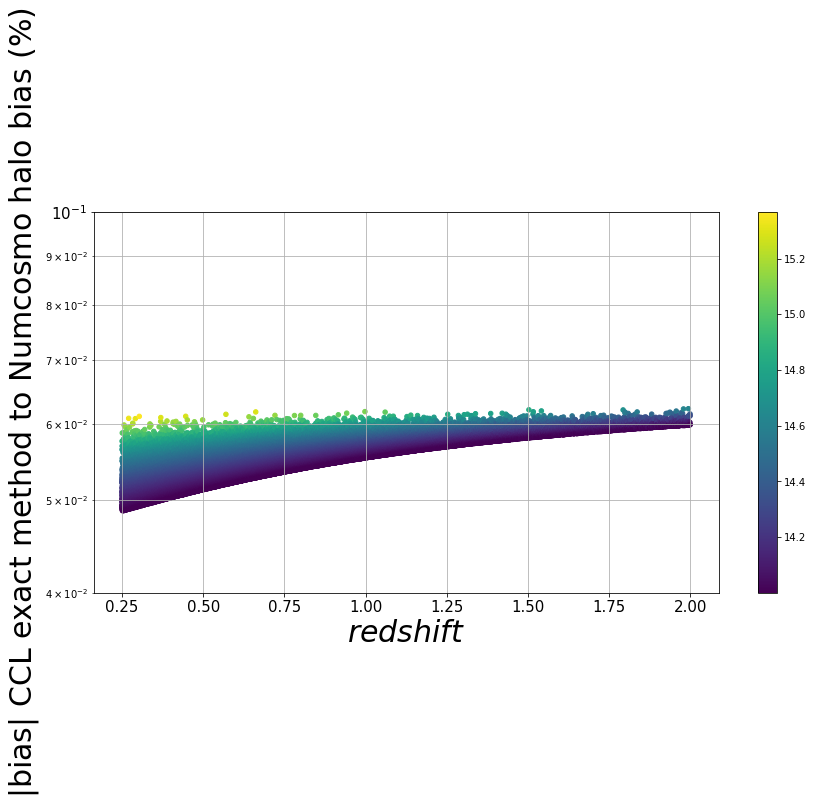

In [20]:
diff = []
for cluster in range(len(dnbias)):
    diff.append(abs(100*(ccl_unbinned_bias[cluster]-dnbias[cluster])/dnbias[cluster]))

plt.figure(figsize = (14,7))
plt.yscale('log')
plt.tick_params(axis='both', which = 'major', labelsize= 15)
plt.scatter(ncdata_Table[0][:], diff, s = 20, c = ncdata_Table['LNM_OBS']/math.log(10))
plt.colorbar()
plt.grid(True, which='both')
plt.xlabel(r'$redshift$', fontsize = 30)
plt.ylabel('|bias| CCL exact method to Numcosmo halo bias $(\%)$', fontsize = 30)
plt.ylim(4e-2,0.1)


# Binned approach



# Compute the integral

$$
 b_{\alpha\beta}^{\rm predicted} = \frac{\Omega_s}{N^{predicted}_{\alpha \beta}}\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\lambda_{\beta}}^{\lambda_{\beta + 1}}d\lambda\int_{\log_{10}M_{min}}^{\log_{10}M_{max}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}b(M,z)P(\lambda|M,z)d\log_{10}M
 $$

In [11]:
#Bins definition
z_edges = np.linspace(0.25, 2, 8)
mass_edges = np.linspace(14, 14.8, 11)

In [12]:
#Using Numcosmo
mass_edges_ln = mass_edges*math.log(10)
t0 = time.time()
ca.prepare(cosmo,cluster_z,cluster_m)
numcosmo_bias_binned = []


for zl, zu in zip (z_edges, z_edges[1:]):
    nc_bin_mass = []
    for lnMl, lnMu in zip (mass_edges_ln, mass_edges_ln[1:]):
        P_bias_bin = ca.intp_bin_d2n_bias(cosmo, cluster_z, cluster_m, [lnMl], [lnMu], None, [zl], [zu], None)/ca.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnMl], [lnMu], None, [zl], [zu], None)
        nc_bin_mass.append(P_bias_bin)
    numcosmo_bias_binned.append(nc_bin_mass)

t1 = time.time()
print('time (seconds) = ' + str(t1-t0))

time (seconds) = 0.02180337905883789


In [13]:
#Using CCL
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobias = halobias_model)
Abundance_exact = clc.Cluster_Abundance_MZ(zbin_edges = z_edges, proxybin_edges = mass_edges, method = 'exact')
t0 = time.time()
ccl_bias_binned = clc.halo_bias_MZ(zbin_edges = z_edges, proxybin_edges = mass_edges, N_th = Abundance_exact, method ='exact')

t1 = time.time()
print('time (seconds) = ' + str(t1-t0))

time (seconds) = 24.283918857574463


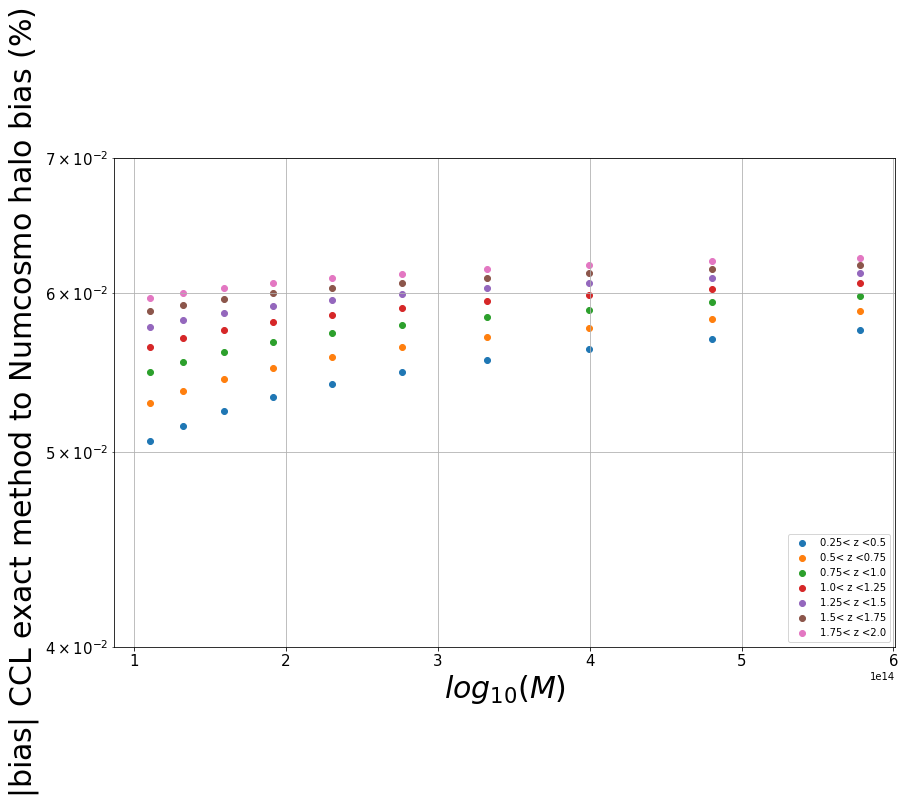

In [21]:
diff = []
for i in range(len(ccl_bias_binned)):
        diff.append(100*abs((numcosmo_bias_binned[i]-ccl_bias_binned[i])/numcosmo_bias_binned[i]))

plt.figure(figsize = (14,9))
plt.yscale('log')
z_ = [np.mean([z_edges[i],z_edges[i+1]]) for i in np.arange(len(z_edges)-1)]
mass = [np.mean([10**mass_edges[i],10**mass_edges[i+1]]) for i in np.arange(len(mass_edges)-1)]
plt.tick_params(axis='both', which="both", labelsize= 15)
legend = []
for i in range(len(z_)):
        plt.scatter(mass, diff[:][i])
        legend.append(str(round(z_edges[i],3))+'< z <'+str(round(z_edges[i+1],3)))
plt.legend(legend,loc =4, fontsize = 10)
plt.grid(True, which="both" )
plt.ylabel('|bias| CCL exact method to Numcosmo halo bias $(\%)$', fontsize = 30)
plt.xlabel(r'$log_{10}(M)$', fontsize = 30)
plt.ylim(4e-2,7e-2)
plt.show()

In [5]:
class Point:
    def __init__(self):
        self._x = 0
        self._y = 0

    def get_x(self):
        return self._x

    def set_x(self, value):
        self._x = value

    def get_y(self):
        return self._y

    def set_y(self, value):
        self._y = value

a = Point()
a.get_x()

NameError: name 'x' is not defined